# Problem 1: Determine the Ground State Structures for the Two Phases 

NOTICE TO BINDER USERS: YOUR NOTEBOOK PROGRESS WILL NOT BE SAVED IF YOU CLOSE THIS WINDOW OR LEAVE IT INACTIVE FOR TOO LONG.

PLEASE DOWNLOAD YOUR NOTEBOOKS AND FILES REGULARLY OR DOWNLOAD THIS REPO AND RUN OFFLINE ON YOUR MACHINE. See "running_offline.md" for more info.

## Part A&B: VASP Input Files 

First, we need to prepare a POSCAR for the diamond cubic structure. To do this, we'll import some classes from the [pymatgen](http://pymatgen.org/) library for python, which is written and maintained by the Materials Project.

In [2]:
from pymatgen import Structure, Lattice, PeriodicSite
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

Now we'll create a lattice for DC silicon.

The diamond cubic structure can be thought of as two interpenetrating face centered cubic (FCC) lattices (Let's start by defining the lattice in the more familiar interpenetrating FCC basis and then simplify it to the primitive unit cell with pymatgen. The coordinates of the atoms in the DC structure are (in terms of the lattice vectors):


$\big[ 0, 0, 0 \big]$, 
$\big[ \frac{1}{4}, \frac{1}{4}, \frac{1}{4} \big]$, 
$\big[ \frac{1}{2}, \frac{1}{2}, 0 \big]$, 
$\big[ \frac{1}{2}, 0, \frac{1}{2}\big]$, 
$\big[ 0, \frac{1}{2}, \frac{1}{2}\big]$,
$\big[ \frac{1}{4}, \frac{3}{4}, \frac{3}{4} \big]$, 
$\big[ \frac{3}{4}, \frac{1}{4}, \frac{3}{4} \big]$, 
$\big[ \frac{3}{4}, \frac{3}{4}, \frac{1}{4} \big]$


In [43]:
# Define the lattice parameter, in Å
lattice_parameter = 5.43

# Create a cubic lattice with the lattice parameter above
cubic_lattice = Lattice.cubic(lattice_parameter)

# Create a list of coordinates (i.e. [[x, y, z], [x2, y2, z2], ...])
DC_coordinates = [[0,0,0], [0.25,0.25,0.25], [0.5,0.5,0], [0.5,0,0.5], [0,0.5,0.5], [0.25,0.75,0.75], [0.75,0.25,0.75], [0.75,0.75,0.25]]

DC_species = ["Si" for coord in DC_coordinates] # creates the list of Si species used when creating the Structure

# Create the structure
Si_DC = Structure(cubic_lattice, species=DC_species, coords=DC_coordinates ) # creates the Structure

# Simplify the structure to a primitive one
Si_DC = SpacegroupAnalyzer(Si_DC).get_primitive_standard_structure()

When you enter "`print(Si_DC)`", you should get something that looks similar to the following (sites may be in different order):

```
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.839590   3.839590   3.839590
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25
  ```

In [44]:
print(Si_DC)

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.839590   3.839590   3.839590
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25


Now, we need to prepare our VASP input files.

First, let's import [Kpoints](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Kpoints), [Incar](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Incar), [Potcar](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Potcar),  and [Pocar](http://pymatgen.org/pymatgen.io.vasp.inputs.html#pymatgen.io.vasp.inputs.Poscar) from *pymatgen* and then write some code to prepare a structure optimization calculation. We'll start off defining where we want everything saved and write a POTCAR corresonding to a PBE calculation of Si there.

In [45]:
from pymatgen.io.vasp.inputs import Kpoints, Poscar, Potcar, Incar

# This is how you create a POTCAR. However, if you don't have access 
# to the VASP pseudopotentials, this command may not work
# POTCAR = Potcar("Si", functional="PBE")

Now lets use the Poscar class to create a POSCAR file for the DC-Si structure we just wrote.

In [46]:
POSCAR = Poscar(Si_DC)
print(POSCAR)

Si2
1.0
-0.000000 2.715000 2.715000
2.715000 0.000000 2.715000
2.715000 2.715000 0.000000
Si
2
direct
0.000000 0.000000 0.000000 Si
0.250000 0.250000 0.250000 Si



Similarly, we can create a KPOINTS file with the Kpoints class...

In [47]:
# fill in this tuple with desired grid dimensions (e.g. (a, b, c))
grid = (6, 6, 6)

# We're using the gamma_automatic constructor here to create a grid centered at Gamma.
KPOINTS = Kpoints.monkhorst_automatic(kpts=grid)

print(KPOINTS)

Automatic kpoint scheme
0
Monkhorst
6 6 6



Now let's create an INCAR file. We could do that by editing the example file directly, but let's do it with code instead so we can automate that process later.

In [122]:
# not ISIF = 2,3
my_incar_params = {"EDIFF" : 0.0004, 
                "EDIFFG" : -0.01, 
                "ENCUT" : 250, 
                "IBRION" : 2, 
                "ISIF" : 7, 
                "ISMEAR" : 0, 
                "SIGMA" : 0.2 , 
                "NSW" : 15,
                "NBANDS" : 8,
                "LREAL" : "False"}

In [123]:
INCAR = Incar.from_dict(my_incar_params)
print(INCAR)

EDIFF = 0.0004
EDIFFG = -0.01
ENCUT = 250
IBRION = 2
ISIF = 7
ISMEAR = 0
LREAL = False
NBANDS = 8
NSW = 15
SIGMA = 0.2



In [124]:
def write_input_set(POTCAR, POSCAR, INCAR, KPOINTS, directory="new_input_set", use_fake_potcar=True):
    
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)

    if not use_fake_potcar:
        POTCAR.write_file("{}/POTCAR".format(directory))
    else:
        from shutil import copyfile
        # Copy over a fake potcar
        copyfile("fake_vasp_data/3kvi0H85jC/POTCAR", "directory")
    
    POSCAR.write_file("{}/POSCAR".format(directory))
    INCAR.write_file("{}/INCAR".format(directory))
    KPOINTS.write_file("{}/KPOINTS".format(directory))
    print("Input set written to '{}'".format(directory))

Okay, let's write these to our directory and then run fake_vasp on it!

In [125]:
# Directory where you want to save the files. e.g. "my_part_1/Si_DC"
my_directory = "Problem_1/Si_DC"

write_input_set(None, POSCAR, INCAR, KPOINTS, directory=my_directory)

Input set written to 'Problem_1/Si_DC'


In [126]:
!python fake_vasp.py Problem_1/Si_DC

No matching pre-computed data for the input files in specified directory were found. Please check your input files and try again.


You should see some new files written to the directory you ran fake_vasp in.

In [127]:
!ls Problem_1/Si_DC

CHG         DOSCAR      INCAR       OUTCAR      REPORT      output.txt
CHGCAR      EIGENVAL    KPOINTS     PCDAT       WAVECAR     vasprun.xml
CONTCAR     IBZKPT      OSZICAR     POSCAR      XDATCAR


You can get the final energy of the converged structure using pymatgen's Outcar class (example below).

In [111]:
from pymatgen.io.vasp.outputs import Outcar
OUTCAR = Outcar(my_directory + "/OUTCAR")
OUTCAR.final_energy

-10.84260713

We can now repeat the same process for the $\beta$-Sn structure. Note we only have to prepare a new POSCAR for this. 

In [133]:
# Define the lattice parameters, in Å
lattice_parameter_a = 4.9
lattice_parameter_c = 2.548

# Create the tetragonal lattice
tetragonal_lattice = Lattice.tetragonal(lattice_parameter_a, lattice_parameter_c)

# Create a list of coordinates (i.e. [ [x1, y1, z1], [x2, y2, z2], ... ])
BSn_coordinates = [[0,0,0], [0.5,0.5,0.5], [0,0.5,0.75], [0.5,0,0.25]]

BSn_species = ["Si" for coord in BSn_coordinates] # creates the list of Si species used when creating the Structure

Si_BSn = Structure(tetragonal_lattice, species=BSn_species, coords=BSn_coordinates) # creates the Structure

#Si_BSn = SpacegroupAnalyzer(Si_BSn).get_primitive_standard_structure()

In [134]:
print(Si_BSn)

Full Formula (Si4)
Reduced Formula: Si
abc   :   4.900000   4.900000   2.548000
angles:  90.000000  90.000000  90.000000
Sites (4)
  #  SP      a    b     c
---  ----  ---  ---  ----
  0  Si    0    0    0
  1  Si    0.5  0.5  0.5
  2  Si    0    0.5  0.75
  3  Si    0.5  0    0.25


In [135]:
my_directory = "Problem_1/Si_BSn"

POSCAR = Poscar(Si_BSn)
print(POSCAR)

write_input_set(None, POSCAR, INCAR, KPOINTS, directory=my_directory)

Si4
1.0
4.900000 0.000000 0.000000
-0.000000 4.900000 0.000000
0.000000 0.000000 2.548000
Si
4
direct
0.000000 0.000000 0.000000 Si
0.500000 0.500000 0.500000 Si
0.000000 0.500000 0.750000 Si
0.500000 0.000000 0.250000 Si

Input set written to 'Problem_1/Si_BSn'


Okay, now let's run fake_vasp on the BSn input files!

In [136]:
!python fake_vasp.py Problem_1/Si_BSn

No matching pre-computed data for the input files in specified directory were found. Please check your input files and try again.


In [137]:
!ls Problem_1/Si_BSn

INCAR   KPOINTS POSCAR


## Part C: Convergence tests

For the convergence tests, we'll need to repeatedly run VASP using different input parameters. Let's start by combining the code we wrote above into a function that writes the input files we need given a structure, ENCUT value, and number of KPOINTS. We'll also include a helper function to make plotting the convergence curves easier.

In [18]:
def make_convergence_calc(structure, ENCUT, n_kpoints, output_dir, incar_params, use_fake_potcar=True):
    if not use_fake_potcar:
        # make POTCAR
        POTCAR = Potcar(["Si"], functional="PBE")
    else:
        POTCAR = None
    
    # make POSCAR from primitive unit cell of structure
    POSCAR = Poscar(SpacegroupAnalyzer(structure).get_primitive_standard_structure())
    
    # make KPOINTS from specified number of kpoints (n,n,n)
    grid = (n_kpoints, n_kpoints, n_kpoints)
    KPOINTS = Kpoints.monkhorst_automatic(kpts=grid)
    
    # Use our previous incar settings as starting point
    incar_params = dict(incar_params) # make a copy so we don't mutate original dict
    incar_params["ENCUT"] = ENCUT
    INCAR = Incar.from_dict(incar_params)
    
    # Write our input set to the directory
    write_input_set(POTCAR, POSCAR, INCAR, KPOINTS, directory=output_dir)
    
    
import matplotlib.pyplot as plt
from math import log

# Helper function to plot convergence test data.
def plot_convergence(parameters, energies, xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                     ylabel="Final Energy (eV/atom)", title="Final Energy vs Cutoff Energy",
                     save_fig=False, filename="DC_ENCUT_conv.png"):
    """Helper function to create convergence plots. 
    
    Arguments:
        parameters (list of int/float): independent variable (e.g. ENCUT or KPOINTS)
        energies (list of float): resulting final energies
        xlabel (str): label for the x-axis
        ylabel (str): label for you y-axis
        title (str): title for the plot
        save_fig (bool): if True, figure is saved as a picture
        filename (str): filename of picture
        """
    
    # plot the data
    plt.plot(parameters, energies, 'rx')
    plt.plot(parameters, energies, 'b-')
    
    # add labels to the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    # saves the plot in convergence_test_results/plots/ (WILL OVERWRITE FILES IF FILENAME IS NOT CHANGED)
    if save_fig:
        plt.savefig("convergence_test_results/plots/DC_ENCUT_conv.png", bbox_inches='tight')
    # show the plot here
    plt.show()
    

Below is an example of how to use this function. We define two lists (one of the parameter we changed and one of the final energies returned by VASP) and then provide those to the function as input arguments.

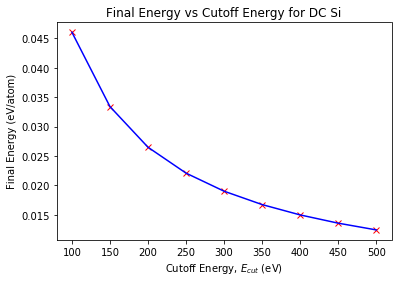

In [19]:
example_ENCUTS = [100, 150, 200, 250, 300, 350, 400, 450, 500]
example_energies = [log(i)/i for i in example_ENCUTS]

# Example usage for plot_convergence
plot_convergence(example_ENCUTS, example_energies, 
                 xlabel="Cutoff Energy, $E_{cut} $ (eV)", 
                 ylabel="Final Energy (eV/atom)", 
                 title = "Final Energy vs Cutoff Energy for DC Si")

Okay, let's create some convergence tests!

In [32]:
# list of ENCUT values (e.g. [ENCUT_1, ENCUT_2, ...])
Ecs = [150, 200, 250, 300, 350]

# writes the ENCUT convergence test input sets to convergence_tests/DC/
for E in Ecs:
    temp = 0
    dirname = "convergence_tests/DC/En_{}_K_{}".format(E, 6)
    # We're using a (6,6,6) k-points grid for this convergence test
    make_convergence_calc(Si_DC, E, 6, output_dir=dirname, incar_params=my_incar_params)
    !python fake_vasp.py convergence_tests/DC/En_{E}_K_{6}
    #OUTCAR = Outcar(dirname + "/OUTCAR")
    #final_energies[temp] = [OUTCAR.final_energy]
    #temp = temp + 1
    
#print(final_energies)

Input set written to 'convergence_tests/DC/En_150_K_6'
No matching pre-computed data for the input files in specified directory were found. Please check your input files and try again.
Input set written to 'convergence_tests/DC/En_200_K_6'
No matching pre-computed data for the input files in specified directory were found. Please check your input files and try again.
Input set written to 'convergence_tests/DC/En_250_K_6'
No matching pre-computed data for the input files in specified directory were found. Please check your input files and try again.
Input set written to 'convergence_tests/DC/En_300_K_6'
No matching pre-computed data for the input files in specified directory were found. Please check your input files and try again.
Input set written to 'convergence_tests/DC/En_350_K_6'
No matching pre-computed data for the input files in specified directory were found. Please check your input files and try again.


In [ ]:
# ENCUT value determined from last convergence test
ENCUT = # YOUR CODE HERE

# list of KPOINTS densities (n, n, n) (e.g. [k1, k2,, k3, ...])
Ks = [(2,2,2), (3,3,3), (4,4,4), (5,5,5), (6,6,6), (7,7,7), (8,8,8), (9,9,9), (10,10,10), (11,11,11), (12,12,12)]

# write the KPOINTS convergence test input sets to convergence_tests/DC/
for K in Ks:
    dirname = "convergence_tests/DC/E_{}_K_{}".format(ENCUT, K)
    make_convergence_calc(Si_DC, E, K, output_dir=dirname, incar_params=my_incar_params)

Now, after you have run fake_vasp in all of these directories (or used a script you wrote to do so) prepare the lists of ENCUT values and final energies and us them to plot the convergence curves.